In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite2d_vrel'
run_name = 'nac2'
data_dir = '../data/'+system_name+'/'+run_name+'/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

# Learning of the 2d kite with a non-constant wind
- The aggregate state is the discretized attack angle and the angle with the relative valocity (values specified in kite.h)
- The wind velocity is based on a simple stream-function
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is a natural actor-critic with advantage parameters. It uses two power law learning rates (the one of the critic part should be much larger) having a burn-in period in which it stays constant (see the first plot of the learning rates)

## Setting the parameters

In [21]:
# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0005 # sec
env_params['ep_length'] = 200 # sec
env_params['decision_time'] = 0.05 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
# attack angles
env_params['alphas'] = [-4, 0, 4, 8, 12, 14, 16, 18, 20]
env_params['CL_alphas'] = [0.05, 0.35, 0.55, 0.75, 0.9, 1.0, 1.08, 1.1, 1.05]
env_params['CD_alphas'] = [0.001, 0.01, 0.03, 0.07, 0.1, 0.13, 0.18, 0.18, 0.21]
env_params['init_alpha'] = len(env_params['alphas'])-1 # index, if larger than len it's random
# angle of relative velocity (bins)
env_params['beta_bins'] = np.linspace(-np.pi, np.pi, 17)
# wind
env_params['wind_type'] = 'stream'
env_params['k_wind'] = 0.5 # 1/sec
env_params['eps_wind'] = 0.2

# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'nac' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 20000000
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 1000

alg_params['init_val_path'] = data_dir + 'init_value.txt' # Value prior, comment for constant values
#alg_params['init_pol_path'] = data_dir + 'init_policy.txt' # Policy prior, comment for flat policy
alg_params['init_values'] = env_params['k_wind']*5*env_params['ep_length']

# Actor learning rate
alg_params['a0'] = 0.05
alg_params['ac'] = 100000
alg_params['a_expn'] = 0.8
alg_params['a_burn'] = 5000000
# Critic learning rate
alg_params['b0'] = 0.0001
alg_params['bc'] = 100000
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = 10000000

Dynamical steps:  2000000000.0
Dynamical time, in seconds:  1000000.0


In [22]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")

In [23]:
# COMPILING C++ SCRIPT
comp_list = np.array(["g++", "-o", "train.exe", "train.cpp", "../lib/nac.cpp", "../lib/utils.cpp", "../lib/wind.cpp", 
            "../lib/envs/kite.cpp", "../lib/envs/kite2d.cpp", "-std=c++17"])
comp_str = ""
for s in comp_list: comp_str+=s+" "
print('To compile from terminal: ')
print(comp_str)

To compile from terminal: 
g++ -o train.exe train.cpp ../lib/nac.cpp ../lib/utils.cpp ../lib/wind.cpp ../lib/envs/kite.cpp ../lib/envs/kite2d.cpp -std=c++17 


## Training analysis

### Learning rate scheduling

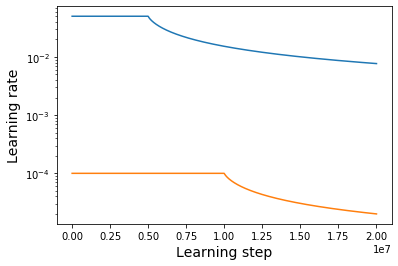

In [24]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Learning rate', fontsize=14)
plt.yscale('log')
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
crit_lr = [ut.p_law_burn(x, alg_params['a_burn'], alg_params['a_expn'], alg_params['a0'], alg_params['ac']) for x in xs]
act_lr = [ut.p_law_burn(x, alg_params['b_burn'], alg_params['b_expn'], alg_params['b0'], alg_params['bc']) for x in xs]

plt.plot(xs, crit_lr)
plt.plot(xs, act_lr)
#plt.savefig(plot_dir+'lr.png', dpi=200)

In [14]:
import numpy as np
v_traj, s_labels = ut.read_traj(data_dir + '/value_traj.txt')
r_traj = np.loadtxt(data_dir + '/return_traj.txt', dtype='float')

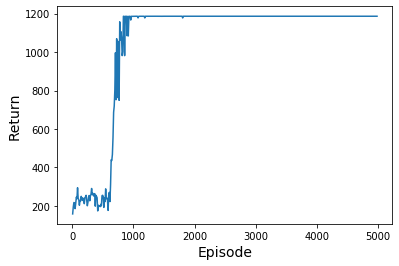

In [15]:
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Return', fontsize=14)
x, y = ut.smooth_traj(r_traj, 10)
plt.plot(x,y)
#plt.savefig(plot_dir+'return.png', dpi=200)

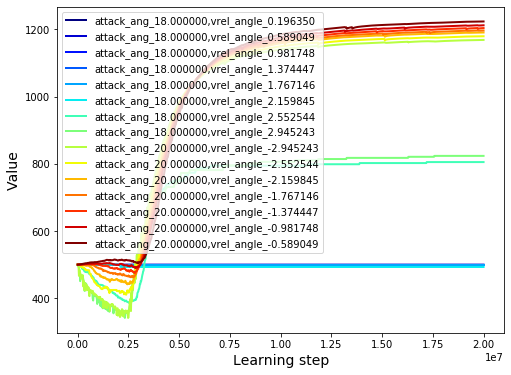

In [19]:
val_fig_name='alp=18'
n_alphas=len(env_params['alphas'])
n_betas=len(env_params['beta_bins'])-2
alphas = [n_alphas-1]
betas = np.arange(n_betas)

colors = plt.cm.jet(np.linspace(0,1,len(alphas)*len(betas)))
plt.figure(figsize=(8,6))
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Value', fontsize=14)
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        plt.plot(xs, v_traj[:,index], lw=2, label=s_labels[index], c=colors[count])
        count+=1
    
plt.legend(loc=2)
#plt.savefig(plot_dir+'values_'+val_fig_name+'.png', dpi=200)

In [17]:
p_traj, s_labels, a_labels = ut.read_policy(data_dir + "policy_traj.txt")

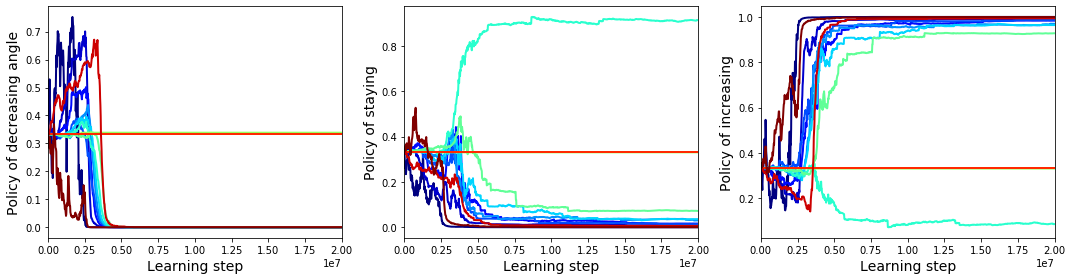

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(alphas)*len(betas)))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Policy of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        ax1.plot(xs, p_traj[:,index,0], c=colors[count], label=s_labels[index], lw=2)
        count += 1
#ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Policy of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        ax2.plot(xs, p_traj[:,index,1], c=colors[count], lw=2)
        count += 1

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Policy of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        ax3.plot(xs, p_traj[:,index,2], c=colors[count], lw=2)
        count += 1
    
plt.tight_layout()
plt.savefig(plot_dir+'policy_'+val_fig_name+'.png', dpi=200)